# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

<b>Описание проекта<br></b>
Заказчик этого исследования — сеть отелей «Как в гостях». <br>
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.<br>
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

### Шаг 1. Откройте файлы с данными

In [1]:
!pip install category_encoders

In [2]:
!pip install shap

In [3]:
!pip install phik

#### Импорт данных

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from category_encoders import TargetEncoder
import shap

from phik.report import plot_correlation_matrix
from phik import report

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
RANDOM_STATE = 12345

#### Обзор данных

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
df_train = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')

In [9]:
df_train.shape

(65229, 25)

In [10]:
df_test.shape

(32412, 25)

In [11]:
df_train.sample(10)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
31210,39150,1,87.0,2016,August,33,12,0,2,3.0,0.0,0.0,BB,ESP,TA/TO,0,0,0,D,0,0,Transient,0,0,2
13066,15737,0,51.0,2016,June,25,14,0,4,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,4
21515,29455,0,41.0,2015,October,42,16,1,2,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,2,3
38717,57072,0,257.0,2015,July,27,1,0,2,2.0,0.0,0.0,HB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,2
55081,73679,0,67.0,2016,July,29,12,0,4,3.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,D,0,0,Transient,0,0,4
64476,83199,0,147.0,2016,December,51,14,0,1,1.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,2,1
18286,26226,0,9.0,2015,August,35,23,2,0,2.0,0.0,0.0,BB,ESP,Direct,0,0,0,A,0,0,Transient,0,0,2
52613,71187,0,220.0,2016,June,23,4,2,1,2.0,0.0,0.0,BB,USA,TA/TO,0,0,0,A,0,0,Transient-Party,0,1,3
58906,77573,0,47.0,2016,September,38,11,2,0,2.0,0.0,0.0,SC,FRA,TA/TO,0,0,0,A,0,0,Transient,0,1,2
40839,59215,0,7.0,2015,September,40,29,0,1,1.0,0.0,0.0,BB,ESP,TA/TO,0,0,0,A,0,0,Transient,0,0,1


In [12]:
df_test.sample(10)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2407,12854,0,0.0,2017,March,13,28,0,1,1.0,0.0,0.0,BB,PRT,Corporate,1,0,4,A,0,0,Transient,0,0,1
5063,22003,0,48.0,2017,April,15,10,1,4,2.0,0.0,0.0,BB,ESP,TA/TO,0,0,0,A,0,0,Transient,1,1,5
11991,49180,1,156.0,2017,April,17,26,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,3
15385,52574,1,150.0,2017,June,24,17,2,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,5
12828,50017,1,56.0,2017,May,18,5,2,6,2.0,0.0,0.0,SC,RUS,TA/TO,0,0,0,A,2,0,Transient,0,0,8
11338,48527,1,81.0,2017,April,15,13,1,3,2.0,0.0,0.0,SC,DEU,TA/TO,0,0,0,A,0,0,Transient,0,2,4
31488,96980,0,73.0,2017,August,33,14,1,3,3.0,0.0,0.0,BB,ESP,TA/TO,0,0,0,D,0,0,Transient,0,0,4
2293,10310,1,0.0,2017,January,4,26,0,1,1.0,0.0,0.0,BB,PRT,Corporate,1,0,5,A,0,0,Transient,0,0,1
25162,90654,0,93.0,2017,May,18,1,1,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,2,3
28880,94372,0,67.0,2017,June,26,30,0,1,2.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,1,1


Описание данных

В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:
* `id` — номер записи;
* `adults`  — количество взрослых постояльцев;
* `arrival_date_year` — год заезда;
* `arrival_date_month` — месяц заезда;
* `arrival_date_week_number` — неделя заезда;
* `arrival_date_day_of_month` — день заезда;
* `babies` — количество младенцев;
* `booking_changes` — количество изменений параметров заказа;
* `children` — количество детей от 3 до 14 лет;
* `country` — гражданство постояльца;
* `customer_type`  — тип заказчика:
    * Contract — договор с юридическим лицом;
    * Group — групповой заезд;
    * Transient — не связано с договором или групповым заездом;
    * Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
* `distribution_channel` — канал дистрибуции заказа;
* `is_canceled` — отмена заказа;
* `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `meal` — опции заказа:  
    * SC — нет дополнительных опций;
    * BB — включён завтрак;
    * HB — включён завтрак и обед;
    * FB — включён завтрак, обед и ужин.
* `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
* `previous_cancellations` — количество отменённых заказов у клиента;
* `required_car_parking_spaces` — необходимость места для автомобиля;
* `reserved_room_type`  — тип забронированной комнаты;
* `stays_in_weekend_nights` — количество ночей в выходные дни;
* `stays_in_week_nights` — количество ночей в будние дни;
* `total_nights` — общее количество ночей;
* `total_of_special_requests` — количество специальных отметок.

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [15]:
df_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [16]:
df_test.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


In [17]:
# уникальные значения признаков
df_train.nunique().sort_values(ascending=False)

id                                65229
lead_time                           369
country                             155
days_in_waiting_list                 97
previous_bookings_not_canceled       58
arrival_date_week_number             53
arrival_date_day_of_month            31
booking_changes                      16
previous_cancellations               15
arrival_date_month                   12
total_nights                         10
stays_in_week_nights                  7
reserved_room_type                    7
total_of_special_requests             6
babies                                5
adults                                5
stays_in_weekend_nights               5
meal                                  5
children                              4
distribution_channel                  4
customer_type                         4
required_car_parking_spaces           4
is_canceled                           2
is_repeated_guest                     2
arrival_date_year                     2


In [18]:
# уникальные значения признаков
df_test.nunique().sort_values(ascending=False)

id                                32412
lead_time                           368
country                             143
days_in_waiting_list                 75
previous_bookings_not_canceled       46
arrival_date_week_number             35
arrival_date_day_of_month            31
booking_changes                      15
total_nights                         10
arrival_date_month                    8
stays_in_week_nights                  7
previous_cancellations                7
reserved_room_type                    7
total_of_special_requests             6
adults                                5
stays_in_weekend_nights               5
required_car_parking_spaces           5
meal                                  5
children                              4
distribution_channel                  4
customer_type                         4
babies                                3
is_canceled                           2
is_repeated_guest                     2
arrival_date_year                     1


Согласно описанию в столбце `meal` должно быть 4 уникальных значения, а в данных их `5`. 

In [19]:
df_train.meal.unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [20]:
df_test.meal.unique()

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

В данных, есть пробелы. Проверим остальные данные на наличие пробелов.

In [21]:
[df_train[_].unique() for _ in df_train.columns]

[array([    0,     1,     2, ..., 84094, 84117, 84121]),
 array([0, 1]),
 array([  7.,  14.,   0.,   9.,  85.,  75.,  23.,  18.,  68.,  37.,  72.,
         48.,  77.,  99.,  40.,  15.,  36.,  70.,  45.,  16., 107.,  47.,
         96., 113.,  50.,   3.,   1.,  10.,   5.,  17.,  93.,  71.,  63.,
         62., 101.,   2.,  81.,  12., 109., 102.,   4.,  92.,  95.,  86.,
         78.,  29.,  30.,  51.,  33.,   8., 100.,  80.,  97.,  64.,  90.,
         27.,  82.,  94., 115., 111.,  98.,  66., 104.,  65.,  55.,  21.,
         88.,  43.,  54., 280.,  24., 103., 249.,  13.,  79.,  35.,  31.,
         34.,  44., 304., 117.,  84., 110.,  59., 116.,  91.,  42.,  60.,
        321.,  32.,  56.,  41.,  76.,  49.,  73., 112.,  39.,  58.,  57.,
         19.,  53.,  38.,   6., 108.,  26., 123.,  28., 118.,  46.,  69.,
         52.,  89.,  61.,  22.,  67., 105.,  25.,  11.,  87., 299.,  74.,
        298., 119.,  20.,  83., 136., 129., 124., 130., 131., 139., 122.,
        106., 137., 120., 135., 150., 1

Похожая ошибка встречается в столбце с признаком `reserved_room_type` — тип забронированной комнаты.<br>
Удалим данные 

In [22]:
for _ in ['meal', 'reserved_room_type']:
    df_train[_] = df_train[_].str.strip()
    display(df_train[_].unique())

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

#### Вывод:
Размер таблицы `hotel_train` - 65'229 наблюжений, а в таблице `hotel_test` - 32'412 наблюдений.

В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:
* `id` — номер записи;
* `adults`  — количество взрослых постояльцев;
* `arrival_date_year` — год заезда;
* `arrival_date_month` — месяц заезда;
* `arrival_date_week_number` — неделя заезда;
* `arrival_date_day_of_month` — день заезда;
* `babies` — количество младенцев;
* `booking_changes` — количество изменений параметров заказа;
* `children` — количество детей от 3 до 14 лет;
* `country` — гражданство постояльца;
* `customer_type`  — тип заказчика:
    * Contract — договор с юридическим лицом;
    * Group — групповой заезд;
    * Transient — не связано с договором или групповым заездом;
    * Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
* `distribution_channel` — канал дистрибуции заказа;
* `is_canceled` — отмена заказа;
* `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `meal` — опции заказа:  
    * SC — нет дополнительных опций;
    * BB — включён завтрак;
    * HB — включён завтрак и обед;
    * FB — включён завтрак, обед и ужин.
* `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
* `previous_cancellations` — количество отменённых заказов у клиента;
* `required_car_parking_spaces` — необходимость места для автомобиля;
* `reserved_room_type`  — тип забронированной комнаты;
* `stays_in_weekend_nights` — количество ночей в выходные дни;
* `stays_in_week_nights` — количество ночей в будние дни;
* `total_nights` — общее количество ночей;
* `total_of_special_requests` — количество специальных отметок.

В обоих таблицах присутствуют пробелы в данных, в столбцах с признаками: 
* `reserved_room_type` — тип забронированной комнаты;
* `meal` — опции заказа.

### Шаг 2. Предобработка и исследовательский анализ данных

In [23]:
#Удаление столбца id
df_train.drop(columns='id', inplace=True)
df_test.drop(columns='id', inplace=True)

#### Пропуски в значениях

In [24]:
df_train.isna().mean()

is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: float64

#### Дубликаты в данных

In [25]:
df_train.duplicated().sum()

21377

In [26]:
df_test.duplicated().sum()

7717

Удалим дубликаты в данных.

In [27]:
df_train.drop_duplicates(inplace=True, ignore_index=True)
df_test.drop_duplicates(inplace=True, ignore_index=True)

#### Целевой признак

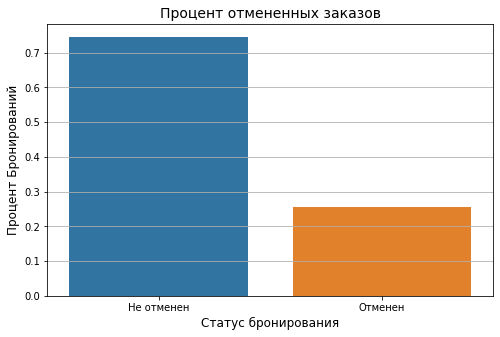

In [28]:
plt.figure(figsize=(8,5))
plt.grid()
plt.title('Процент отмененных заказов', fontsize = 14)

sns.barplot(x=df_train.is_canceled.unique(),
            y=df_train.is_canceled.value_counts(normalize=True)
           )

plt.xlabel('Статус бронирования', fontsize = 12)
plt.ylabel('Процент Бронирований', fontsize = 12)
plt.xticks(ticks=[0, 1], labels=['Не отменен', 'Отменен'])
None

In [29]:
df_train.is_canceled.value_counts(normalize=True)

0    0.745781
1    0.254219
Name: is_canceled, dtype: float64

#### Количество бронирований по неделям в году

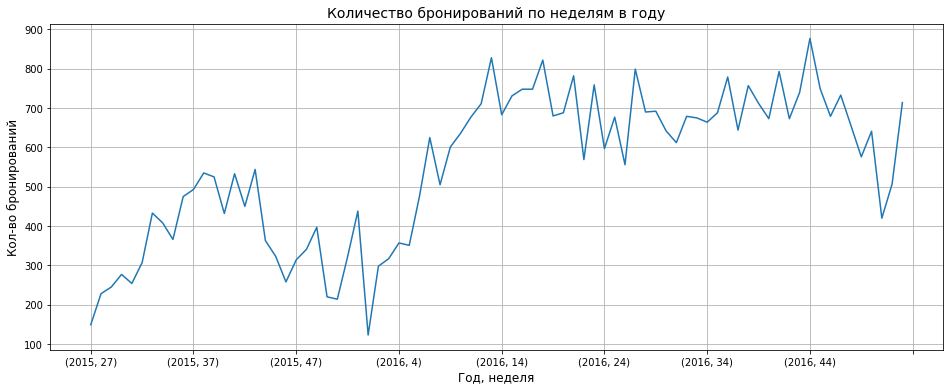

In [30]:
df_train.pivot_table(index=['arrival_date_year',
                            'arrival_date_week_number'],
                     values='is_canceled',
                     aggfunc='count')\
        .plot(legend=None,
              figsize=(16,6),
              grid=True)

plt.title('Количество бронирований по неделям в году', fontsize = 14)

plt.xlabel('Год, неделя', fontsize = 12)
plt.ylabel('Кол-во бронирований', fontsize = 12)

None

На графике видна сезонность, большинство бронирований приходинстя на середину года, а в начале и конце снижается.

#### Тип бронируемой комнаты

In [31]:
df_train.groupby('reserved_room_type',dropna=False)['is_canceled'].agg(['count','mean'])

,count,mean
reserved_room_type,,
A,30445,0.244901
B,745,0.296644
C,227,0.189427
D,8423,0.285884
E,2254,0.223159
F,1178,0.286078
G,580,0.310345


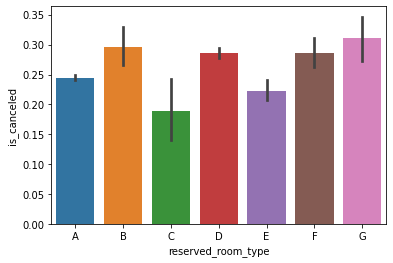

In [32]:
sns.barplot(data=df_train,
            x='reserved_room_type',
            y='is_canceled',
            order=['A','B','C','D','E','F','G'])
None

#### Парковка для автомобиля

In [33]:
df_train.groupby('required_car_parking_spaces',dropna=False)['is_canceled'].agg(['count','mean'])

,count,mean
required_car_parking_spaces,,
0,40253,0.276948
1,3587,0.000000
2,11,0.000000
3,1,0.000000


Клиенты, которым требуется место для автомобиля, не отменяют бронь.

In [34]:
def distribution_plots(data, title):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    sns.distplot(data, ax=ax[0])
    ax[0].set_ylabel('Плотность')
    ax[0].set_title(title, fontsize=18)

    sns.boxplot(data, ax=ax[1])
    ax[1].set_title(title, fontsize=18)
    plt.show()
def distribution(data):
    columns = [_ for _ in df_train.columns if (df_train[_].nunique() > 2) & (df_train[_].dtypes != 'object')]
    for column in columns:
        distribution_plots(data[column], column)

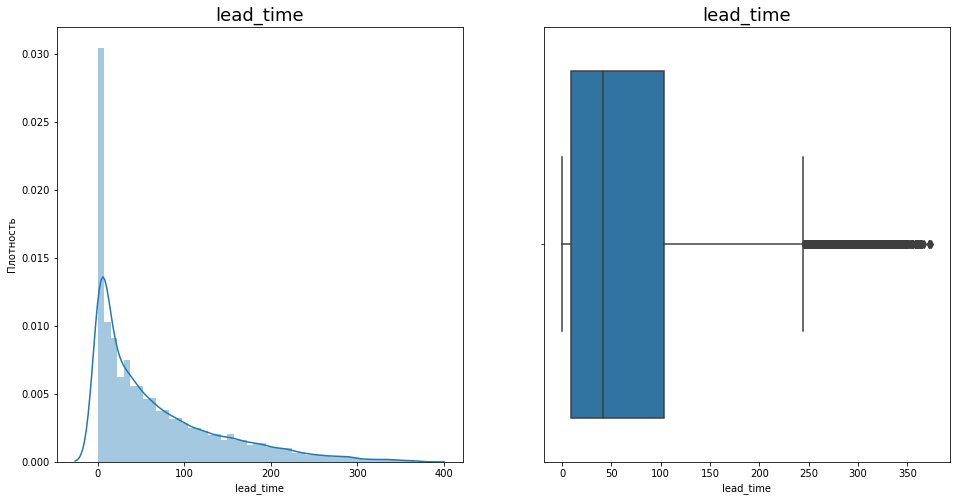

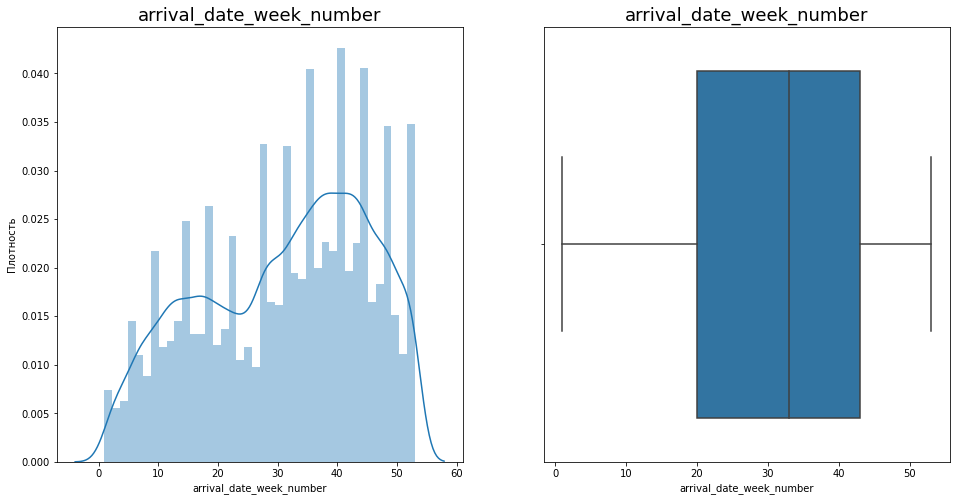

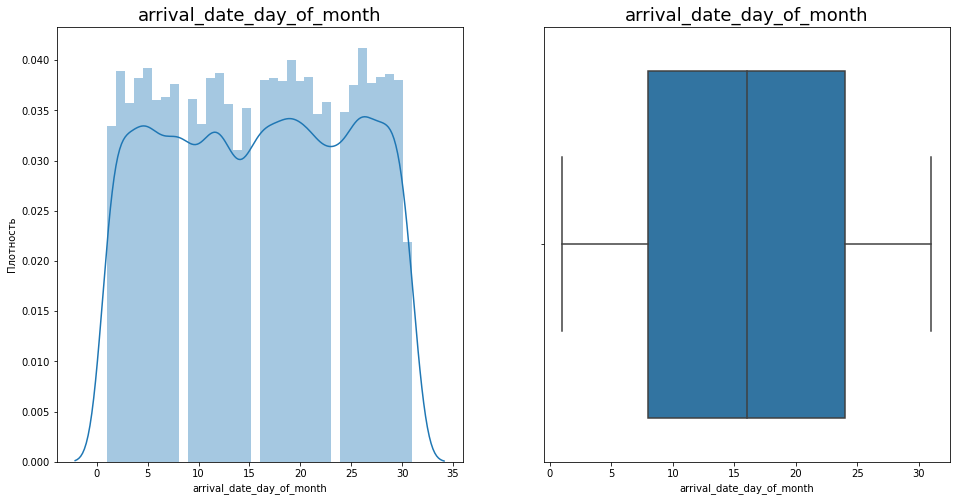

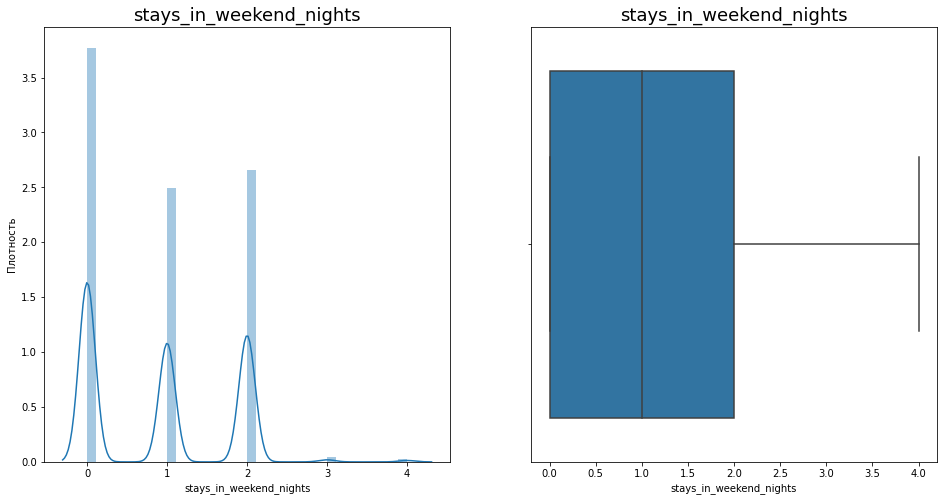

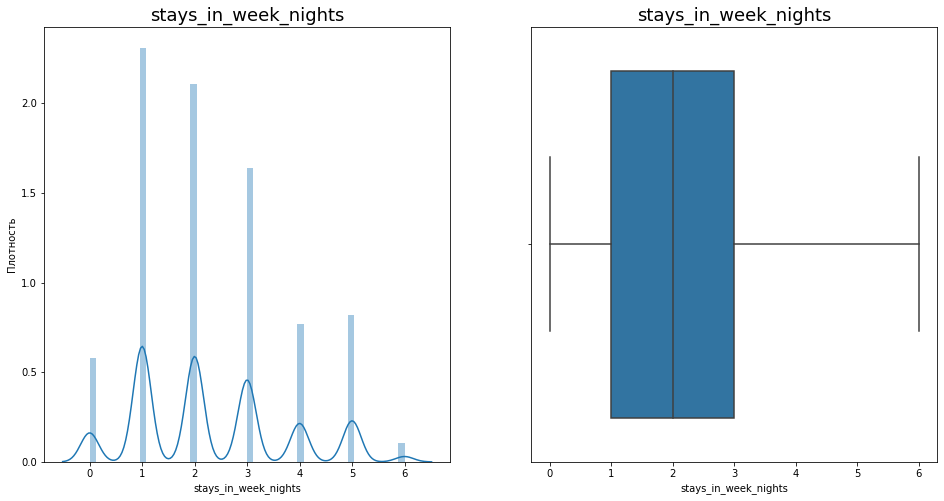

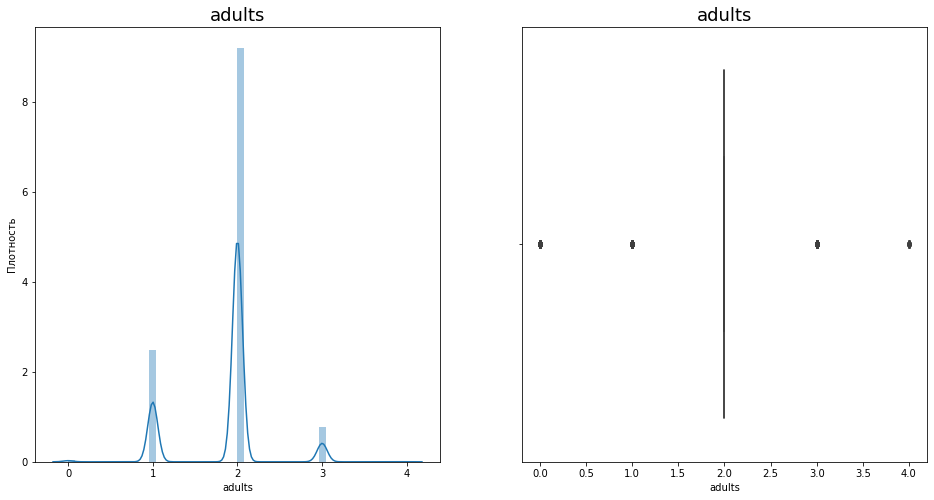

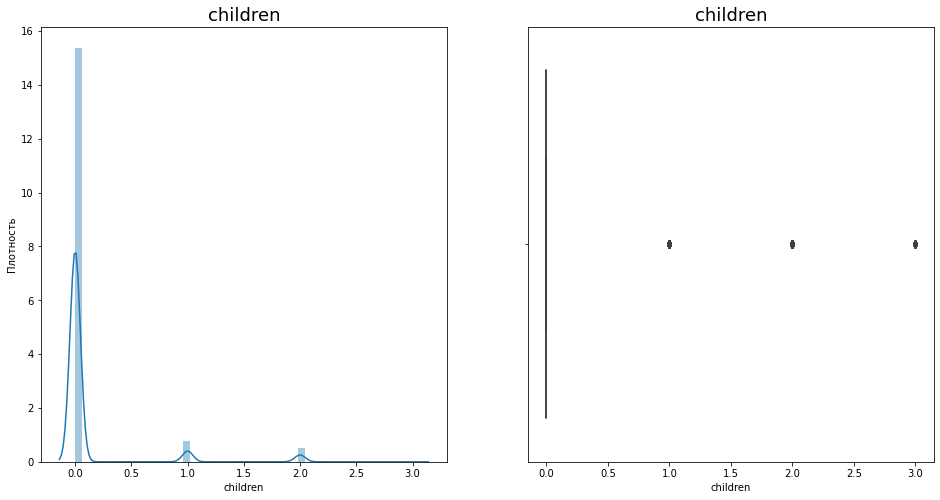

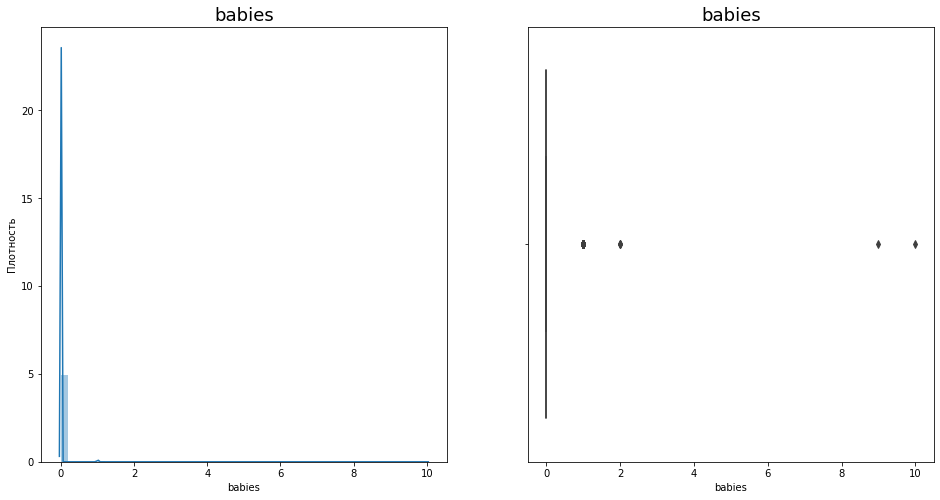

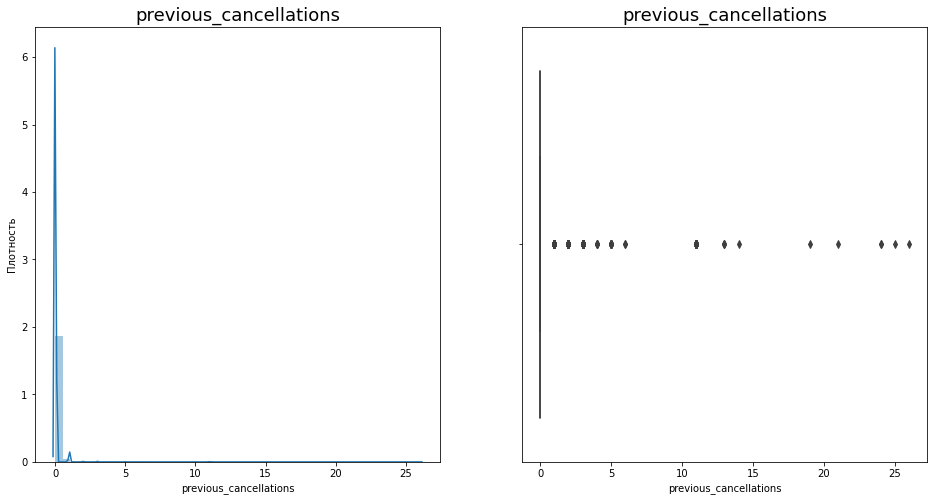

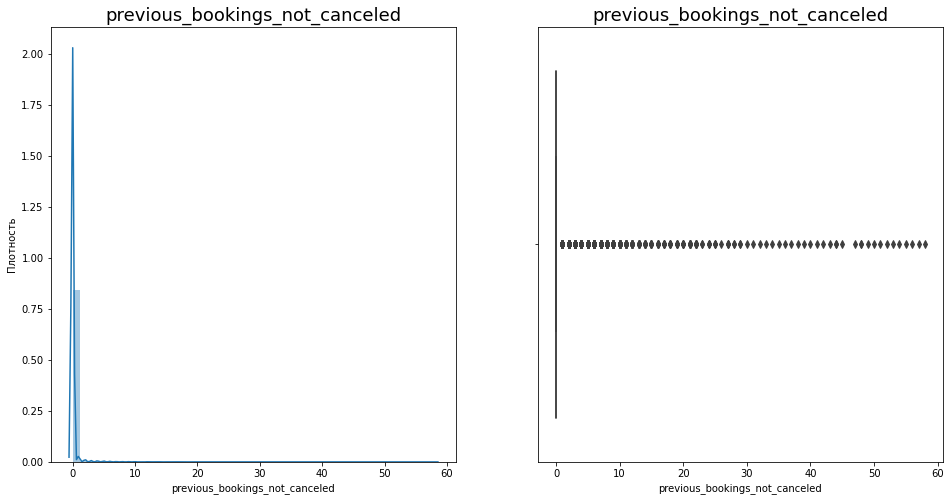

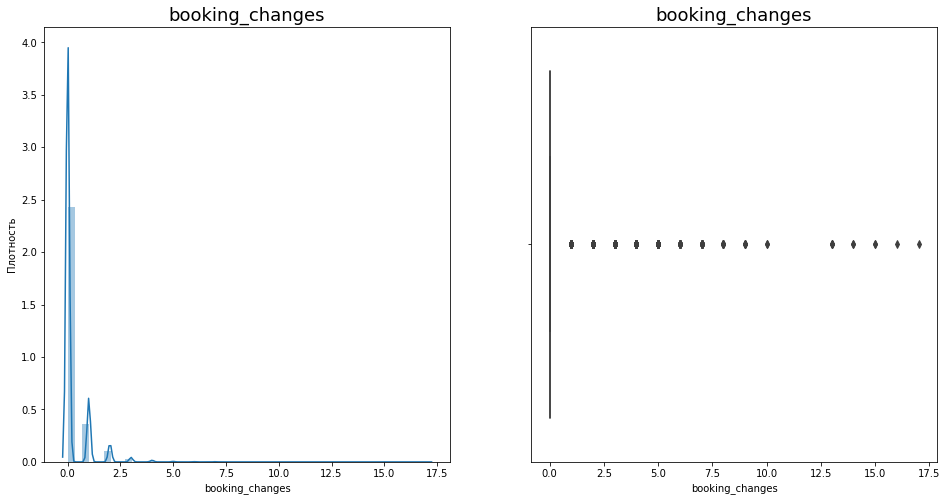

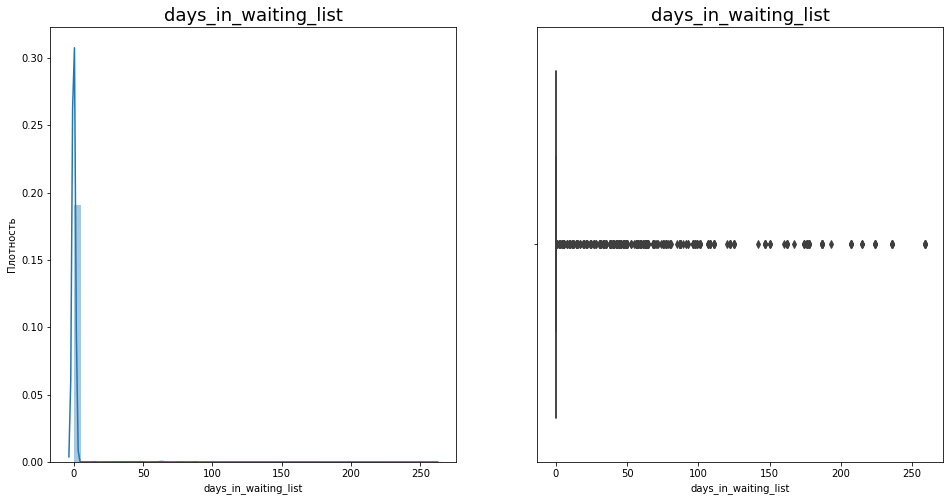

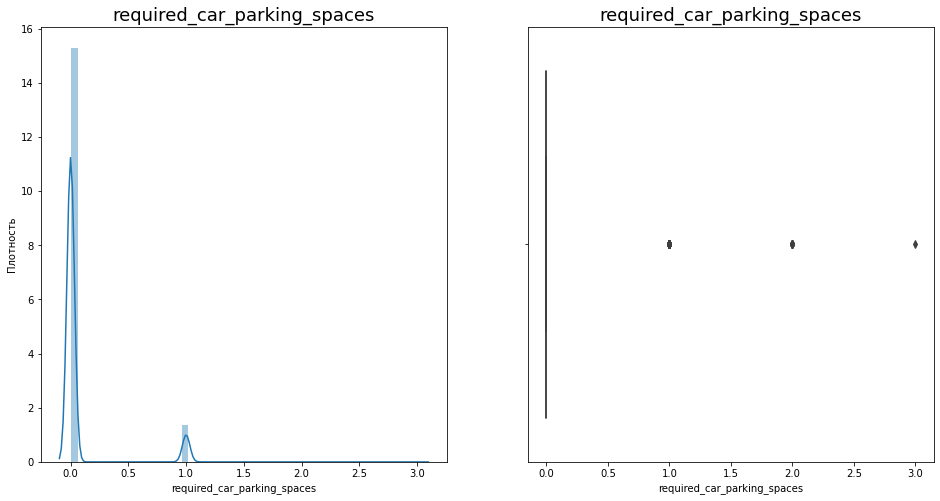

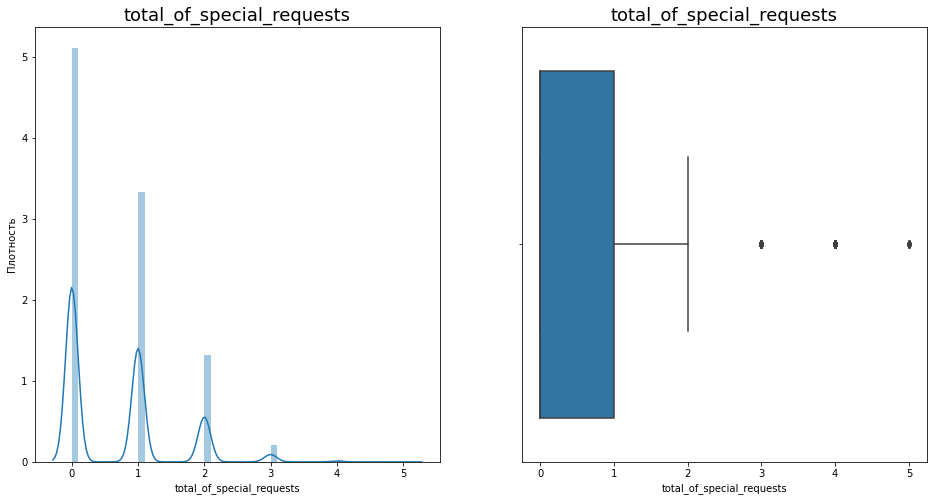

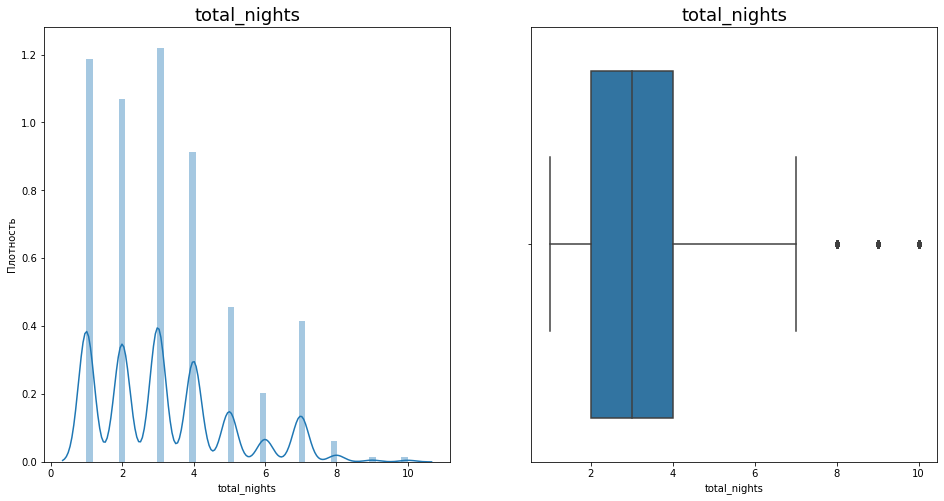

In [35]:
distribution(df_train)

Большинство клиентов бронируют номер на срок от 1 до 4 ночей

In [36]:
df_train.query('adults == 0').shape[0]

164

In [37]:
df_train.drop(df_train.query('adults == 0').index, inplace=True)
df_test.drop(df_test.query('adults == 0').index, inplace=True)

#### Корреляция

In [38]:
numeric = list(df_train.select_dtypes('number').columns)
interval_cols = ['is_canceled', 'lead_time', 'arrival_date_year',
 'arrival_date_week_number', 'arrival_date_day_of_month', 'adults',\
                 'children', 'babies', 'meal', 'country', \
                 'distribution_channel', 'previous_bookings_not_canceled', \
                 'reserved_room_type', 'booking_changes', 'days_in_waiting_list',\
                 'customer_type', 'required_car_parking_spaces',\
                 'total_of_special_requests', 'total_nights']

phik_overview = df_train[numeric].phik_matrix(interval_cols=interval_cols)

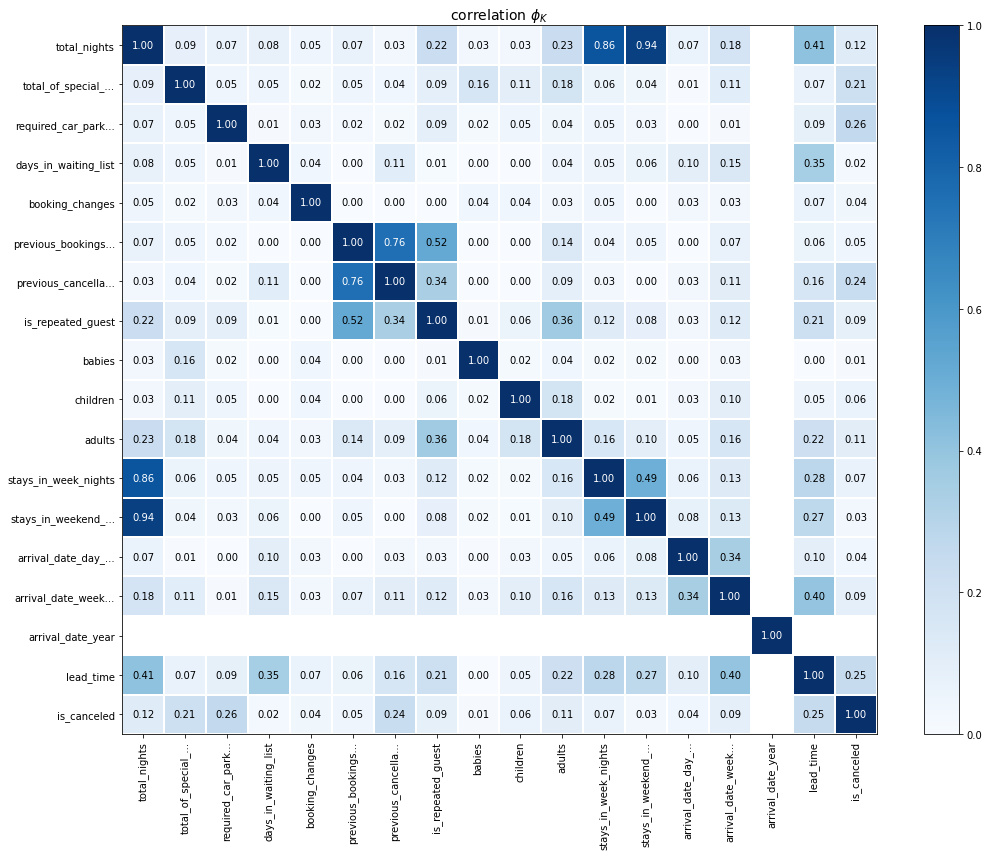

In [39]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='Blues',
                        title=r'correlation $\phi_K$',
                        figsize=(15, 12))

In [40]:
# Построение матрицы корреляции признаков
#numeric = list(df_train.select_dtypes('number').columns)
#plt.figure(figsize=(15, 12))
#sns.heatmap(df_train[numeric].corr(method='spearman'), annot=True, fmt='.1f');
#None

Признаки `stays_in_weekend_nights`, `stays_in_week_nights` и `total_nights` имеют мультиколлинеарность. Оставим столбец `total_nights`.

Также имеют мультиколлиеарность признаки `previous_cancellations`, `previous_bookings_not_canceled` и `is_repeated_guest`. Оставим пирзнак `previous_bookings_not_canceled`.

In [41]:
df_train = df_train.drop(['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1)
df_test = df_test.drop(['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1)

df_test = df_test.drop(['is_repeated_guest', 'previous_cancellations'], axis=1)
df_train = df_train.drop(['is_repeated_guest', 'previous_cancellations'], axis=1)

#### Вывод:

* Отменяется ~25% брони. Наблюдается дисбаланс целевого признака.
* Пик бронирований приходится на середину года, тогда как в начале и в конце возможны снижения из-за сезонности.
* Столбец с непрерывными значениями `lead_time` имеет логнормальное распределение и выбросы.
* Клиенты бронирубщие парковочные места под авто, праетически не отменяют бронирование.
* Более дорогие номера чаще отменяют, но их и чаще бронируют.
* Клиенты, которым требуется место для автомобиля, не отменяют бронь.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [42]:
price_service = pd.DataFrame({'reserved_room_type' : [i for i in sorted(df_test.reserved_room_type.unique())],
                         'price_per_night' : [1000, 800, 600, 550, 500, 450, 350],
                         'service_price' : [400, 350, 350, 150, 150, 150, 150]})
df_test = df_test.merge(price_service, on='reserved_room_type', how='left')

In [43]:
month_ratio = pd.DataFrame({'arrival_date_month' : [i for i in df_test.arrival_date_month.unique()],
                          'ratio' : [1, 1, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4]})
df_test = df_test.merge(month_ratio, on='arrival_date_month', how='left')
df_test.sample(10)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_per_night,service_price,ratio
11829,1,207.0,2017,August,31,1,2.0,0.0,0.0,BB,ITA,TA/TO,0,A,0,0,Transient,0,0,4,1000,400,1.4
17846,0,57.0,2017,April,16,21,2.0,0.0,0.0,BB,CHE,Direct,0,F,0,0,Transient,0,0,2,450,150,1.2
17441,0,173.0,2017,April,15,11,2.0,1.0,0.0,BB,DEU,TA/TO,0,A,2,0,Transient,0,0,4,1000,400,1.2
11593,1,48.0,2017,July,30,24,2.0,0.0,0.0,SC,FRA,TA/TO,0,A,0,0,Transient,0,2,2,1000,400,1.4
10717,1,116.0,2017,June,25,22,2.0,1.0,0.0,HB,ESP,TA/TO,0,A,0,0,Transient,0,1,3,1000,400,1.4
4854,0,0.0,2017,May,19,12,2.0,0.0,0.0,BB,PRT,Direct,0,C,0,0,Transient,1,0,1,600,350,1.2
14483,0,14.0,2017,February,7,15,1.0,0.0,0.0,BB,PRT,TA/TO,0,A,0,0,Transient,0,1,1,1000,400,1.0
16030,0,62.0,2017,March,11,15,1.0,0.0,0.0,SC,PRT,TA/TO,0,A,0,0,Transient,0,1,4,1000,400,1.2
18477,0,2.0,2017,May,18,4,1.0,0.0,0.0,BB,PRT,TA/TO,0,A,0,0,Transient,0,0,1,1000,400,1.2
16155,0,72.0,2017,March,11,16,2.0,0.0,0.0,SC,IRL,TA/TO,0,A,0,0,Transient,0,2,5,1000,400,1.2


In [44]:
def profit(data):
    if data['is_canceled'] == 0:
        income = data['price_per_night'] * data['ratio'] * data['total_nights']
        costs = data['service_price'] * (1 + data['total_nights'] // 2)
    else:
        income = 0
        costs = data['service_price'] + (data['price_per_night'] * data['ratio'])
    profit = income - costs
    return profit

In [45]:
df_test['profit'] = df_test.apply(profit, axis=1)
df_test.sample(10)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_per_night,service_price,ratio,profit
22286,0,277.0,2017,July,28,13,2.0,0.0,0.0,BB,GBR,TA/TO,0,D,0,0,Transient,0,1,3,550,150,1.4,2010.0
9354,1,322.0,2017,May,18,5,2.0,0.0,0.0,BB,PRT,TA/TO,0,A,0,0,Transient-Party,0,0,1,1000,400,1.2,-1600.0
18094,0,123.0,2017,April,17,24,2.0,0.0,0.0,BB,FRA,Direct,0,A,0,0,Transient,0,1,4,1000,400,1.2,3600.0
1838,0,6.0,2017,May,20,16,1.0,0.0,0.0,BB,PRT,Corporate,5,A,0,0,Transient,0,0,1,1000,400,1.2,800.0
16220,0,3.0,2017,March,12,20,1.0,0.0,0.0,BB,IRL,TA/TO,0,D,0,0,Transient,0,1,2,550,150,1.2,1020.0
1168,1,26.0,2017,June,25,18,2.0,0.0,0.0,BB,CN,TA/TO,0,A,0,0,Transient,0,1,5,1000,400,1.4,-1800.0
11360,1,15.0,2017,July,28,15,1.0,0.0,0.0,BB,DNK,TA/TO,0,A,0,0,Transient,0,2,2,1000,400,1.4,-1800.0
12671,0,0.0,2017,February,6,7,2.0,0.0,0.0,BB,PRT,TA/TO,3,A,2,0,Group,0,0,3,1000,400,1.0,2200.0
9886,1,270.0,2017,May,21,21,2.0,0.0,0.0,HB,BEL,TA/TO,0,A,0,0,Transient,0,1,5,1000,400,1.2,-1600.0
2146,0,14.0,2017,March,13,30,2.0,0.0,0.0,BB,PRT,TA/TO,0,D,0,0,Transient,0,1,2,550,150,1.2,1020.0


In [46]:
f'Прибыль за 8 месяцев 2017 года без депозита составляет: {df_test.profit.sum()} руб.'

'Прибыль за 8 месяцев 2017 года без депозита составляет: 32607610.0 руб.'

### Шаг 4. Разработка модели ML

In [47]:
features = ['lead_time', 'arrival_date_day_of_month', 'adults',
           'children', 'meal', 'country', 'distribution_channel',
           'previous_bookings_not_canceled', 'reserved_room_type',
           'booking_changes', 'customer_type',
           'required_car_parking_spaces', 'total_nights']

#### Кодирование признаков

In [48]:
enc_col = ['meal', 'country', 'distribution_channel', \
           'reserved_room_type', 'customer_type']

In [49]:
encoder = TargetEncoder()
for _ in enc_col:
    df_train[_] = encoder.fit_transform(df_train[_], df_train['is_canceled'])
    df_test[_] = encoder.transform(df_test[_], df_test['is_canceled'])

#### Разделение на обучающую тестовую выборки

In [50]:
X_train = df_train[features]
y_train = df_train['is_canceled']

In [51]:
X_test = df_test[features]
y_test = df_test['is_canceled']

In [52]:
scaler = StandardScaler()
scaler.fit(X_train)
features_train = scaler.transform(X_train)
features_test = scaler.transform(X_test)

#### Увеличение выборки

In [53]:
#def upsample(features, target, repeat):
#    features_zeros = features[target == 0]
#    features_ones = features[target == 1]
#    target_zeros = target[target == 0]
#    target_ones = target[target == 1]
#
#    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
#    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
#
#    features_upsampled, target_upsampled = shuffle(
#        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
#
#    return features_upsampled, target_upsampled
#
#X_train, y_train = upsample(X_train, y_train, 3)

#### Логистическая регрессия

In [54]:
params = {
    'penalty':['l1','l2'],
    'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'class_weight': ['balanced']
}

lr_grid = GridSearchCV(LogisticRegression(solver='liblinear',
                                          random_state=RANDOM_STATE),
                                          params,
                                          cv=5,
                                          scoring='roc_auc')
lr = lr_grid.fit(X_train, y_train)

In [55]:
f'Оптимальные параметры: {lr.best_params_}'

"Оптимальные параметры: {'C': 1000, 'class_weight': 'balanced', 'penalty': 'l1'}"

In [56]:
f'Лучшее значение roc_auc: {lr.score(X_train, y_train)}'

'Лучшее значение roc_auc: 0.7688395275108175'

In [57]:
#lr = lr.best_estimator_
#
#y_pred = lr.predict(X_test)
#y_score = lr.predict_proba(X_test)[:,1]
#lr_roc_auc = roc_auc_score(y_test, y_score)
#lr_roc_auc

#### Cлучайный лес

In [58]:
%%time
parameters = {
    'n_estimators': [10, 20, 50, 100, 200, 300],
    'max_depth': range(5, 10),
    'min_samples_leaf': range(2, 4),
    'class_weight': ['balanced']
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                    parameters,
                    cv=5,
                    scoring='roc_auc',
                    verbose=2)

rf = rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=2, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=2, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=2, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=2, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=2, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=2, n_estimators=20; total time=   0.2s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=2, n_estimators=20; total time=   0.2s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=2, n_estimators=20; total time=   0.2s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=2, n_estimators=20; total time=   0.3s
[CV] END class_weight=balance

In [59]:
display(f'Значение roc_auc: {rf.best_score_}')
display(f'Лучшие параметры: {rf.best_params_}')

'Значение roc_auc: 0.7887778112552141'

"Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 200}"

#### Выбор Модели

In [60]:
predictict_model_scores = pd.DataFrame(
    data=[('Logistic Regression',
           lr.best_score_),
          ('Random Forest',
           rf.best_score_)],
    columns=['model', 'roc_auc'])
predictict_model_scores

,model,roc_auc
0,Logistic Regression,0.752069
1,Random Forest,0.788778


Модель, обеспечивающая лучший показатель точности тестирования - `Случайный Лес`.

In [61]:
rf = rf.best_estimator_

In [62]:
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)[:,1]

In [63]:
rf_f1 = f1_score(y_test, y_pred)
rf_f1

0.5438443475343844

In [64]:
y_score_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf = rf.predict(X_test)

rf_roc_auc = roc_auc_score(y_test, y_score_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)

In [65]:
predictict_model_scores = pd.DataFrame(
    data=[
          ('Random Forest',
           rf_roc_auc,
           rf_f1,
           rf_precision,
           rf_recall)],
    columns=['model', 'roc_auc', 'f1', 'precision', 'recall'])
predictict_model_scores

,model,roc_auc,f1,precision,recall
0,Random Forest,0.78027,0.543844,0.567012,0.522496


In [66]:
df_test['rf_pred'] = y_pred_rf
df_test.sample(10)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_per_night,service_price,ratio,profit,rf_pred
15699,0,2.0,2017,March,10,5,1.0,0.0,0.0,0.254074,0.373984,0.283187,0,0.254074,0,0,0.273364,0,0,7,1000,400,1.2,6800.0,0
3401,0,8.0,2017,February,8,25,2.0,0.0,0.0,0.254074,0.351816,0.283187,0,0.254074,0,0,0.273364,0,1,3,1000,400,1.0,2200.0,1
23753,0,171.0,2017,August,33,14,2.0,0.0,0.0,0.254074,0.221766,0.283187,0,0.254074,1,0,0.273364,1,0,2,1000,400,1.4,2000.0,0
13195,0,2.0,2017,January,1,4,2.0,0.0,0.0,0.254074,0.155542,0.283187,0,0.254074,0,0,0.273364,0,1,5,1000,400,1.0,3800.0,0
21209,0,219.0,2017,June,25,20,1.0,0.0,0.0,0.254074,0.166424,0.283187,0,0.254074,1,0,0.273364,0,1,5,1000,400,1.4,5800.0,0
18494,0,58.0,2017,May,18,2,2.0,0.0,0.0,0.254074,0.166424,0.283187,0,0.254074,0,0,0.273364,0,0,3,1000,400,1.2,2800.0,0
13828,0,10.0,2017,January,4,23,2.0,0.0,0.0,0.254074,0.155542,0.283187,0,0.254074,0,0,0.273364,0,0,6,550,150,1.0,2700.0,0
21740,0,164.0,2017,June,26,28,3.0,0.0,0.0,0.254074,0.206278,0.283187,0,0.254074,0,0,0.273364,0,0,8,550,150,1.4,5410.0,1
5843,0,171.0,2017,June,26,30,2.0,0.0,0.0,0.254074,0.166862,0.283187,0,0.254074,1,0,0.273364,0,1,2,1000,400,1.4,2000.0,0
3962,0,22.0,2017,March,13,31,2.0,0.0,0.0,0.254074,0.351816,0.283187,0,0.254074,0,0,0.273364,0,2,2,1000,400,1.2,1600.0,1


In [67]:
rf_cm = confusion_matrix(y_test, y_pred_rf)

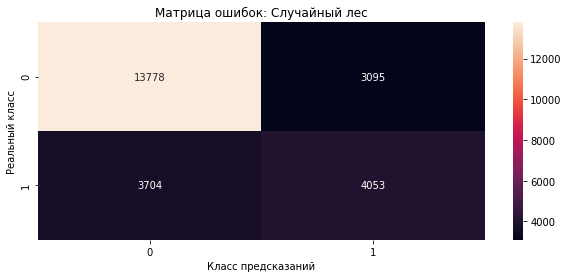

In [68]:
plt.figure(figsize=(10,4))

sns.heatmap(rf_cm,
            annot=True,
            fmt='g')

plt.title('Матрица ошибок: Случайный лес')
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс')
None

In [69]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
total = tn + fp + fn + tp

display(f'Правильно классифицированные: {np.round((tp+tn)/total*100)}%')
display(f'Правильно классифицированные отмененные бронирования: {np.round(tp/(tp+fn)*100)}%')
display(f'Правильно классифицированые не отмененные бронирования: {np.round(tn/(tn+fp)*100)}%')
display(f'Прогнозируемые отмененные бронирования, которые на самом деле отменены: {np.round(tp/(tp+fp)*100)}%')
display(f'Прогнозируемые не отмененные бронирования, которые на самом деле не отменены: {np.round(tn/(tn+fn)*100)}%')

'Правильно классифицированные: 72.0%'

'Правильно классифицированные отмененные бронирования: 52.0%'

'Правильно классифицированые не отмененные бронирования: 82.0%'

'Прогнозируемые отмененные бронирования, которые на самом деле отменены: 57.0%'

'Прогнозируемые не отмененные бронирования, которые на самом деле не отменены: 79.0%'

#### Расчет прибыли с внедрением модели

При расчете учитываем:

* если система ошибочно предсказала отказ клиента и предложила ему предоплату, то он не отказывается от брони и все равно приехал. Поэтому income и costs такие же как и если система верно предсказывает что отмены не будет.
* если система ошибочно предсказала, что клиент приедет, то отель не предложил ему предоплату, а клиент заказ в итоге отменил, поэтому убыток - это разовое обслуживание.
* если система верно предсказала отмену брони, то клиенту предлагается депозит, а в расход идет только разовое обслуживание.

In [70]:
def profit_pred(row, col):
    if row['is_canceled']==0:
        income = row['price_per_night']*row['total_nights']*row['ratio']
        costs = row['service_price']*round(row['total_nights']//2)
    elif (row[col]==0) and (row['is_canceled']==1):
        income = 0
        costs = row['service_price']
    elif (row[col]==1) and (row['is_canceled']==1):
        income= row['price_per_night']*0.8
        costs = row['service_price']
    profit_pred = income - costs
    return profit_pred

In [72]:
df_test['rf_profit_pred'] = df_test.apply(profit_pred, col='rf_pred', axis=1)

In [73]:
df_test.sample(15)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_per_night,service_price,ratio,profit,rf_pred,rf_profit_pred
3376,0,0.0,2017,February,9,26,2.0,0.0,0.0,0.254074,0.351816,0.139483,0,0.254074,0,0,0.273364,0,0,2,1000,400,1.0,1200.0,0,1600.0
6793,1,37.0,2017,January,2,12,3.0,0.0,0.0,0.254074,0.351816,0.283187,0,0.254074,0,0,0.273364,0,1,1,550,150,1.0,-700.0,1,290.0
21452,0,205.0,2017,June,26,27,2.0,0.0,0.0,0.254074,0.157895,0.283187,0,0.254074,0,0,0.273364,0,1,3,1000,400,1.4,3400.0,0,3800.0
7616,1,19.0,2017,February,9,27,3.0,0.0,0.0,0.254074,0.351816,0.283187,0,0.254074,1,0,0.273364,0,0,4,550,150,1.0,-700.0,1,290.0
8318,1,76.0,2017,April,13,1,3.0,0.0,0.0,0.254074,0.161502,0.283187,0,0.254074,0,0,0.273364,0,0,7,550,150,1.2,-810.0,0,-150.0
8286,1,72.0,2017,March,13,31,2.0,0.0,0.0,0.254074,0.351816,0.283187,0,0.254074,0,0,0.273364,0,1,3,1000,400,1.2,-1600.0,1,400.0
4075,0,152.0,2017,April,14,5,1.0,0.0,0.0,0.254074,0.166862,0.283187,0,0.254074,1,0,0.169959,0,0,4,1000,400,1.2,3600.0,0,4000.0
21487,0,6.0,2017,June,26,30,2.0,0.0,0.0,0.254074,0.197995,0.283187,0,0.254074,0,0,0.169959,0,1,1,1000,400,1.4,1000.0,0,1400.0
158,1,77.0,2017,February,6,10,2.0,0.0,0.0,0.254074,0.325557,0.283187,0,0.254074,0,0,0.273364,0,0,4,1000,400,1.0,-1400.0,1,400.0
12279,1,294.0,2017,August,33,16,2.0,1.0,0.0,0.254074,0.150617,0.283187,0,0.254074,0,0,0.273364,0,2,7,1000,400,1.4,-1800.0,0,-400.0


In [74]:
display(f'Прибыль после обучения модели Random Forest: {df_test.rf_profit_pred.sum()}')

'Прибыль после обучения модели Random Forest: 48889620.0'

In [75]:
display(f'Модель Random Forest принесёт компании выручку: {df_test.rf_profit_pred.sum() - df_test.profit.sum()}')

'Модель Random Forest принесёт компании выручку: 16282010.0'

#### Вывод:

Было обучено две модели:
* Случайный лес (roc_auc = 0.78)
* Логистическая регрессия (roc_auc = 0.75)

Выбрана модель `Случайного леса`, которая показала лучшу предсказательную способность.

Прибыль до внедрения модели: 32'607'610<br>
Прибыль после внедрения модели: 48'889'620 

Выручка после внедрения модели: 16'282'010

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [76]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

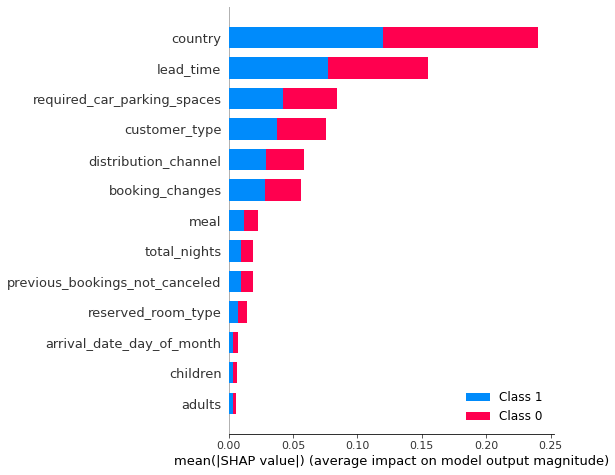

In [77]:
shap.summary_plot(shap_values, X_test)

In [78]:
fi = pd.DataFrame({'features' : X_train.columns,
                   'score' : rf.feature_importances_})
fi.sort_values(by='score', ascending=False)

,features,score
5,country,0.273133
0,lead_time,0.244854
11,required_car_parking_spaces,0.169759
10,customer_type,0.079513
6,distribution_channel,0.056664
9,booking_changes,0.050064
12,total_nights,0.035206
7,previous_bookings_not_canceled,0.021752
8,reserved_room_type,0.018060
4,meal,0.017509


Признаки, который оказали самое сильное влияние на предсказание модели:
* `country` — гражданство постояльца;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `required_car_parking_spaces` — необходимость места для автомобиля;
* `customer_type`  — тип заказчика;
* `distribution_channel` — канал дистрибуции заказа.

### Шаг 6. Напишите общий вывод

Опишите модель, которая решает задачу с наибольшей выгодой для бизнеса. Дайте бизнесу рекомендации по результатам проделанной работы.

Исследовательский анализ целевого признака:

* Отменяется ~25% брони. Наблюдается дисбаланс целевого признака.
* Пик бронирований приходится на середину года, тогда как в начале и в конце возможны снижения из-за сезонности.
* Столбец с непрерывными значениями `lead_time` имеет логнормальное распределение и выбросы.
* Клиенты бронирубщие парковочные места под авто, праетически не отменяют бронирование.
* Более дорогие номера чаще отменяют, но их и чаще бронируют.
* Клиенты, которым требуется место для автомобиля, не отменяют бронь.

Разработка модели ML:

Было обучено две модели:
* Случайный лес (roc_auc = 0.78)
* Логистическая регрессия (roc_auc = 0.75)

Выбрана модель `Случайного леса`, которая показала лучшу предсказательную способность.

Матрица ошибок модели Случайный лес:
* Правильно классифицированные: 72.0%
* Правильно классифицированные отмененные бронирования: 58.0%
* Правильно классифицированые не отмененные бронирования: 79.0%
* Прогнозируемые отмененные бронирования, которые на самом деле отменены: 56.0%
* Прогнозируемые не отмененные бронирования, которые на самом деле не отменены: 80.0%

Прибыль до внедрения модели: 32'607'610<br>
Прибыль после внедрения модели: 48'889'620 

Выручка после внедрения модели: 16'282'010